## 1.Setup Basic Parameters

In [1]:
import numpy as np

# Parameters
Tmax = 60
D = 6  # Number of locations
L = 1  # Number of locations connected to the outside world
n = np.array([0, 20000, 30000, 1200, 1500, 3200])  # Population at each location

## 2. Create Connectivity Matrix W

In [2]:
def create_connectivity_matrix(D, L):
    W = np.zeros((D, D), dtype=int)
    
    # Manually input the specified connections
    W[0, 1] = 3200
    W[0, 2] = 5500
    # Locations 1 to 4, 1 to 5, and 1 to 6 have 0 people moving to them, which is already the default value
    
    W[1, 2] = 400
    W[1, 3] = 500
    W[1, 4] = 700
    W[1, 5] = 200
    
    W[2, 3] = 40
    W[2, 4] = 50
    W[2, 5] = 100
    
    W[3, 4] = 55
    W[3, 5] = 10
    
    W[4, 5] = 77
    
    # Make the matrix symmetrical to ensure the same number that enters also leaves
    W = W + W.T
    
    # Ensure the diagonal is zero
    np.fill_diagonal(W, 0)
    return W

W = create_connectivity_matrix(D, L)

In [18]:
W

array([[   0, 3200, 5500,    0,    0,    0],
       [3200,    0,  400,  500,  700,  200],
       [5500,  400,    0,   40,   50,  100],
       [   0,  500,   40,    0,   55,   10],
       [   0,  700,   50,   55,    0,   77],
       [   0,  200,  100,   10,   77,    0]])

In [3]:
import pandas as pd

W = create_connectivity_matrix(D, L)

# Convert the matrix to a DataFrame for better visualization
W_df = pd.DataFrame(W, columns=[f"Location {i+1}" for i in range(D)], index=[f"Location {i+1}" for i in range(D)])
W_df

,Location 1,Location 2,Location 3,Location 4,Location 5,Location 6
Location 1,0,3200,5500,0,0,0
Location 2,3200,0,400,500,700,200
Location 3,5500,400,0,40,50,100
Location 4,0,500,40,0,55,10
Location 5,0,700,50,55,0,77
Location 6,0,200,100,10,77,0


## 3.Initialize State Vectors

In [4]:
# Initialize state vectors
x = np.zeros((D, 4), dtype=float)  # Use float type for the state vectors

for i in range(D):
    if n[i] == 0:
        x[i] = np.zeros(4)  # Explicitly set to zero for locations with zero population
    else:
        # Directly assign the percentages
        percentages = np.array([0.80, 0.05, 0.05, 0.10])  # Susceptible, Exposed, Infected, Recovered
        x[i] = percentages * n[i]  # Scale by population
        x[i] = np.round(x[i]).astype(int)  # Round to integer

In [5]:
# Convert the state vectors to a DataFrame for better visualization
state_vectors_df = pd.DataFrame(x, columns=['Susceptible', 'Exposed', 'Infected', 'Recovered'], 
                                index=[f"Location {i+1}" for i in range(D)])
state_vectors_df

,Susceptible,Exposed,Infected,Recovered
Location 1,0.0,0.0,0.0,0.0
Location 2,16000.0,1000.0,1000.0,2000.0
Location 3,24000.0,1500.0,1500.0,3000.0
Location 4,960.0,60.0,60.0,120.0
Location 5,1200.0,75.0,75.0,150.0
Location 6,2560.0,160.0,160.0,320.0


## 4. Implement the Migration Logic

In [6]:
def balanced_migration_step(W, x, lockdown=False):
    D = W.shape[0]
    Delta_out = np.zeros_like(x, dtype=float)  # Change dtype to float
    Delta_in = np.zeros_like(x, dtype=float)   # Change dtype to float

    # If it's during lockdown, reduce the connectivity by a certain factor
    if lockdown:
        W_reduced = W * 0.1  # Reduce connections by 90%
    else:
        W_reduced = W

    for i in range(D):
        for j in range(D):
            if i != j and W_reduced[i, j] > 0:
                for cat in range(4):
                    proportion = x[i, cat] / x[i].sum() if x[i].sum() > 0 else 0
                    Delta_out[i, cat] += W_reduced[i, j] * proportion

    for i in range(D):
        for j in range(D):
            if i != j and W_reduced[i, j] > 0:
                Delta_in[j] += Delta_out[i] * W_reduced[i, j] / W_reduced[i].sum() if W_reduced[i].sum() > 0 else 0

    x_new = x - np.round(Delta_out).astype(int) + np.round(Delta_in).astype(int)

    return x_new

In [7]:
x_new = balanced_migration_step(W, x)

In [8]:
x_new

array([[ 6960.,   435.,   435.,   870.],
       [13440.,   840.,   840.,  1680.],
       [19600.,  1226.,  1226.,  2450.],
       [  960.,    60.,    60.,   120.],
       [ 1200.,    75.,    75.,   150.],
       [ 2560.,   160.,   160.,   320.]])

## 5. Implement Infection Dynamics

In [9]:
def infection_step(x, lockdown=False):
    α = 0.60 * (0.5 if lockdown else 1)  # Transmission rate is halved during lockdown
    β = 0.20  # Recovery rate
    γ = 0.30  # Progression rate from exposed to infectious
    D = x.shape[0]
    x_updated = np.zeros_like(x)
    for i in range(D):
        n = x[i, :].sum()
        if n > 0:
            S, E, I, R = x[i, 0], x[i, 1], x[i, 2], x[i, 3]
            δ_SE = np.random.binomial(S, α*I/n if n > 0 else 0)
            δ_EI = np.random.binomial(E, γ)
            δ_IR = np.random.binomial(I, β)
            x_updated[i] = [S - δ_SE, E + δ_SE - δ_EI, I + δ_EI - δ_IR, R + δ_IR]
    return x_updated

## 6. Run the Simulation

In [10]:
# Initialize history array to store state of each location on each day
lockdown_start = 10
lockdown_end = lockdown_start + 20
history = np.zeros((Tmax, D, 4), dtype=int)

# Run the simulation
for t in range(Tmax):
    #lockdown
    is_lockdown = lockdown_start <= t < lockdown_end
    # Migration step
    x = balanced_migration_step(W, x, lockdown=is_lockdown)
    # Infection step
    x = infection_step(x, lockdown=is_lockdown)

    # Record the state for the day
    history[t] = x

# Convert history to a DataFrame for better visualization (optional)
# This step creates a DataFrame showing the state of each location on each day
history_df = pd.DataFrame(history.reshape(Tmax * D, 4), 
                          columns=['Susceptible', 'Exposed', 'Infected', 'Recovered'],
                          index=[f"Day {t // D + 1}, Location {t % D + 1}" for t in range(Tmax * D)])


In [11]:
history_df

,Susceptible,Exposed,Infected,Recovered
"Day 1, Location 1",6769,506,462,963
"Day 1, Location 2",13034,971,949,1846
"Day 1, Location 3",19008,1450,1364,2680
"Day 1, Location 4",933,72,62,133
"Day 1, Location 5",1176,74,85,165
...,...,...,...,...
"Day 60, Location 2",2778,71,142,13814
"Day 60, Location 3",4068,81,216,20135
"Day 60, Location 4",199,3,11,980
"Day 60, Location 5",248,7,12,1239


In [12]:
x

array([[1.4450e+03, 2.9000e+01, 7.9000e+01, 7.1540e+03],
       [2.7780e+03, 7.1000e+01, 1.4200e+02, 1.3814e+04],
       [4.0680e+03, 8.1000e+01, 2.1600e+02, 2.0135e+04],
       [1.9900e+02, 3.0000e+00, 1.1000e+01, 9.8000e+02],
       [2.4800e+02, 7.0000e+00, 1.2000e+01, 1.2390e+03],
       [5.3100e+02, 9.0000e+00, 2.9000e+01, 2.6300e+03]])

In [13]:
history

array([[[ 6769,   506,   462,   963],
        [13034,   971,   949,  1846],
        [19008,  1450,  1364,  2680],
        [  933,    72,    62,   133],
        [ 1176,    74,    85,   165],
        [ 2484,   184,   188,   344]],

       [[ 6540,   567,   559,  1033],
        [12611,  1104,  1044,  2042],
        [18394,  1645,  1515,  2949],
        [  898,    85,    74,   144],
        [ 1131,    99,    92,   178],
        [ 2404,   212,   203,   381]],

       [[ 6270,   670,   586,  1174],
        [12159,  1247,  1162,  2232],
        [17718,  1859,  1686,  3239],
        [  862,    99,    75,   165],
        [ 1083,   120,    99,   198],
        [ 2315,   244,   210,   431]],

       ...,

       [[ 1460,    34,    91,  7120],
        [ 2817,    85,   147, 13756],
        [ 4108,   105,   232, 20055],
        [  198,     7,    13,   978],
        [  253,     7,    14,  1231],
        [  535,    16,    28,  2618]],

       [[ 1452,    38,    75,  7141],
        [ 2797,    78,   148,

## 7. Plot

In [14]:
import matplotlib.pyplot as plt

# Plotting the results for each location through time
compartment_labels = ['Susceptible', 'Exposed', 'Infected', 'Recovered']
compartment_colors = ['yellow', 'orange', 'red', 'green']

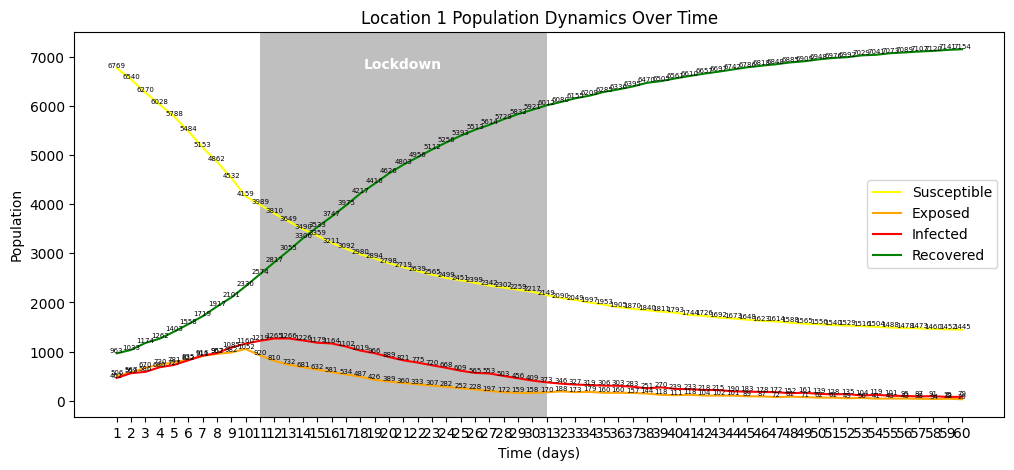

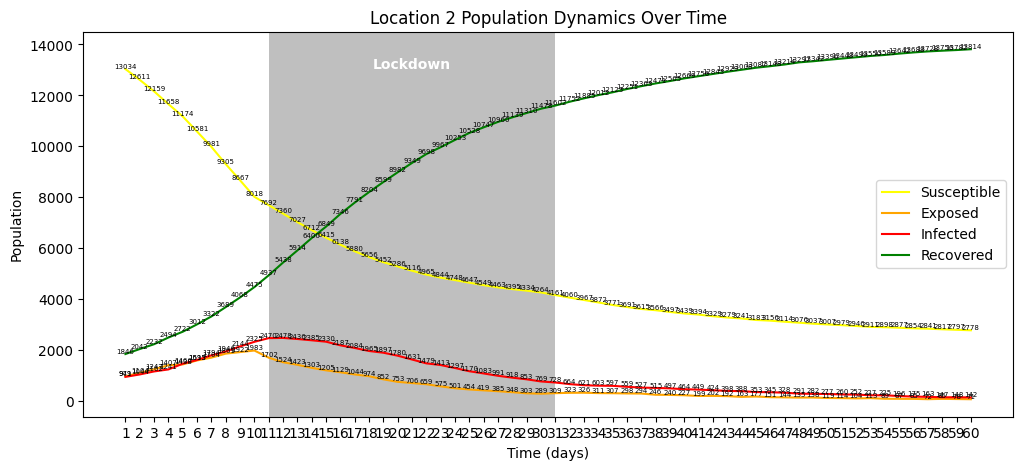

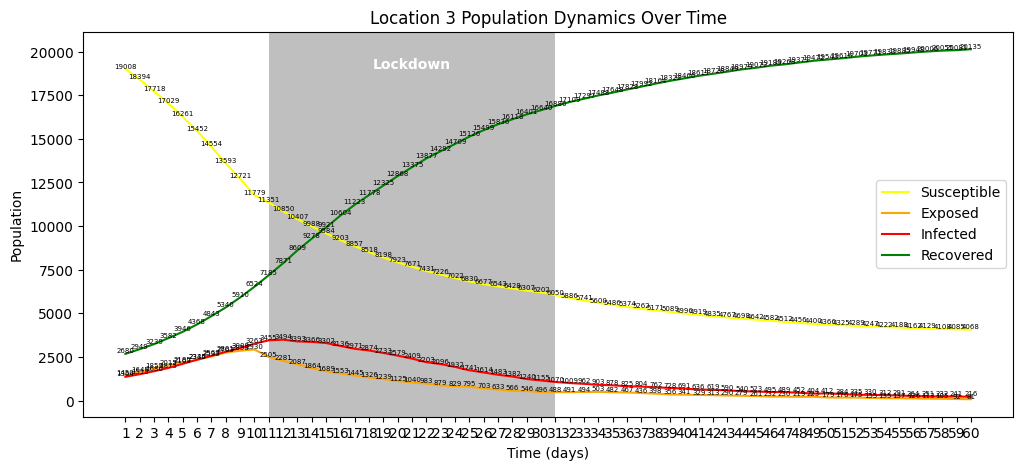

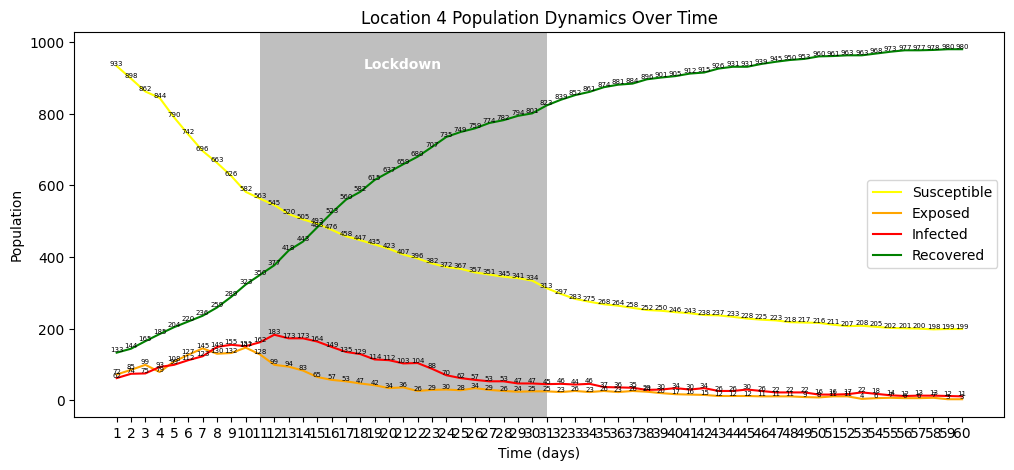

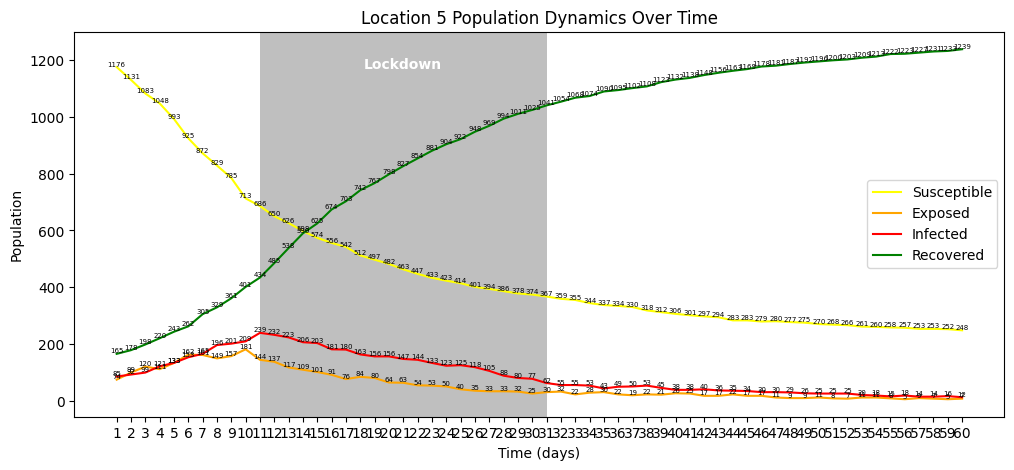

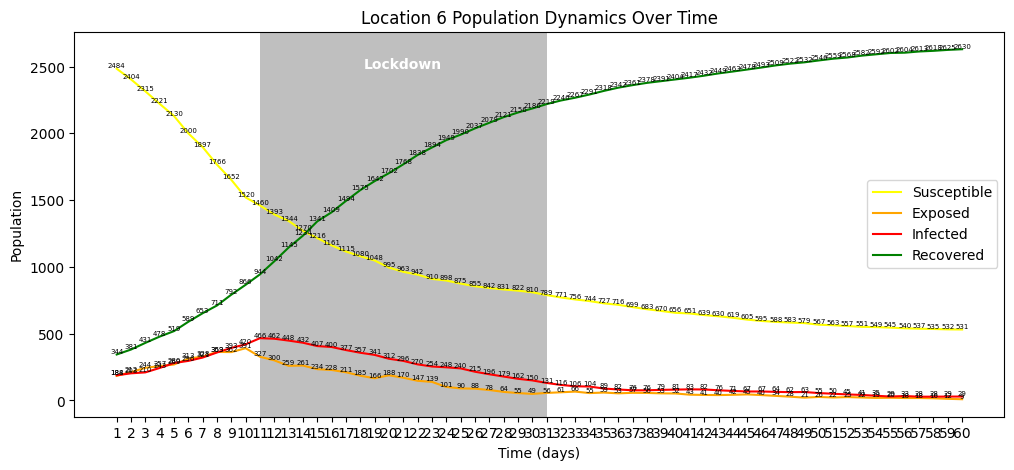

In [16]:
# Plotting the results for each location through time
for i in range(D):
    plt.figure(figsize=(12, 5))
    for j in range(4):
        # Extracting the specific compartment data for each location
        compartment_data = history[:, i, j]
        days = np.arange(len(compartment_data))  # Days of the simulation
        plt.plot(days, compartment_data, label=compartment_labels[j], color=compartment_colors[j])

        # Adding labels to each point
        for day, value in enumerate(compartment_data):
            plt.text(day, value, f'{int(value)}', fontsize=5, ha='center', va='bottom')

    # Set x-axis to show days starting from 1, aligning them with the data points
    max_days = len(history[:, i, 0])
    plt.xticks(ticks=np.arange(max_days), labels=np.arange(1, max_days + 1))

    plt.title(f"Location {i+1} Population Dynamics Over Time")
    plt.xlabel("Time (days)")
    plt.ylabel("Population")
    plt.legend()
    plt.grid(False)

    # Highlight the lockdown period for each location plot
    plt.axvspan(lockdown_start, lockdown_end, color='grey', alpha=0.5, lw=0)
    plt.text((lockdown_start + lockdown_end) / 2, plt.ylim()[1] * 0.9, 'Lockdown',
             horizontalalignment='center', color='white', weight='bold')

    plt.show()